# Preprocessing

## Featurizing

In [1]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv

%cd /home/jovyan/ASMSA/mydev

import os, sys

repo_dir = os.getcwd()   
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

from src.utils import split_dataset, plot_latent_space, process_trajectory
from src.asmsa_callbacks import callbacks
from src.vae import asmsa_beta_vae

nn_model = 'vae'
latent_dim = 2

2025-08-08 16:19:54.855187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 16:19:54.868248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 16:19:54.872074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 16:19:54.881310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 16:19:55.490066: W tensorflow/compiler/tf2

[Errno 2] No such file or directory: '/home/jovyan/ASMSA/mydev'
/home/tedeschg/prj/ASMSA/mydev


In [2]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)

<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x7ae6c79af1c0>

In [3]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [4]:
ca_indices, n_ca, bb_indices, n_bb, features_normalized, scaler_coords, scaler_angles, coords = process_trajectory(tr, conf)
features_normalized.shape

(50001, 558)

## NN preprocessing

In [5]:
# Uso:
ds_train, ds_val, ds_test, ds_all = split_dataset(features_normalized, train_size=70, val_size=15, batch_size=64, seed=42)

I0000 00:00:1754662799.290798  253155 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662799.308511  253155 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662799.308678  253155 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1754662799.309365  253155 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Dataset Statistics:
  Train: 35000 samples, 546 batches
  Val:   7500 samples, 118 batches
  Test:  7501 samples, 118 batches
  Batch size: 64


# VAE

In [6]:
'''
Batch Norm, nel caso, va prima della layer activation)
'''

'\nBatch Norm, nel caso, va prima della layer activation)\n'

In [7]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

cb = callbacks(log_dir, latent_dim, monitor="val_loss", model=nn_model)

beta_vae, encoder, decoder = asmsa_beta_vae(
    n_features=features_normalized.shape[1], 
    latent_dim=latent_dim,
    beta=0.0001,
    )

In [8]:
beta_vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=cb)


Warmup: start from beta = 0.000100 until beta = 8.000000 in 500 epoche.
→ Epoca 1: beta = 0.000100
Epoch 1/500


I0000 00:00:1754662804.260075  253208 service.cc:146] XLA service 0x7ae51801c6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754662804.260098  253208 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-08-08 16:20:04.335304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-08 16:20:04.892742: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 45/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 2.9577e-04 - loss: 0.1911 - reconstruction_loss: 0.1908

I0000 00:00:1754662807.491105  253208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


537/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 8.3889e-04 - loss: 0.1465 - reconstruction_loss: 0.1457
Epoch 1: val_loss improved from inf to 0.13860, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - kl_loss: 8.3955e-04 - loss: 0.1463 - reconstruction_loss: 0.1455 - val_kl_loss: 8.0725e-04 - val_loss: 0.1386 - val_reconstruction_loss: 0.1378 - learning_rate: 0.0010
→ Epoca 2: beta = 0.016100
Epoch 2/500
  1/546 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - kl_loss: 8.3184e-04 - loss: 0.1258 - reconstruction_loss: 0.1250

/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


537/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 7.9828e-04 - loss: 0.1259 - reconstruction_loss: 0.1251
Epoch 2: val_loss improved from 0.13860 to 0.13664, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.9813e-04 - loss: 0.1259 - reconstruction_loss: 0.1251 - val_kl_loss: 7.9716e-04 - val_loss: 0.1366 - val_reconstruction_loss: 0.1358 - learning_rate: 0.0010
→ Epoca 3: beta = 0.032100
Epoch 3/500
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 7.8643e-04 - loss: 0.1240 - reconstruction_loss: 0.1232
Epoch 3: val_loss improved from 0.13664 to 0.13456, saving model to vae_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.8643e-04 - loss: 0.1240 - reconstruction_loss: 0.1232 - val_kl_loss: 7.8840e-04 - val_loss: 0.1346 - val_reconstruction_loss: 0.1338 - learning_rate: 0.0010
→ Epoca 4: beta = 0.048099
Epoch 4/500
543/546 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 7.9829e-04 - loss: 0.1224 - reconstruction_loss: 0.1216
Epoch 4: val_l

In [9]:
src = f"vae_{latent_dim}d.keras"
dest = "/home/tedeschg/prj/ASMSA/mydev/models/"

!mv {src} {dest}

tensorboard --logdir logs/autoencoder --host localhost --port 6006

# Decode and visualize

In [10]:
encoder.save('./models/encoder_vae.keras')
decoder.save('./models/decoder_vae.keras')


In [11]:
for batch_x, _ in ds_test.take(1):
    sample_x = batch_x[30]  
    break
    
sample_x_batch = tf.expand_dims(sample_x, axis=0)
z_mean, z_log_var, test = encoder.predict(sample_x_batch)

z_mean

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


array([[1.475933  , 0.39134157]], dtype=float32)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


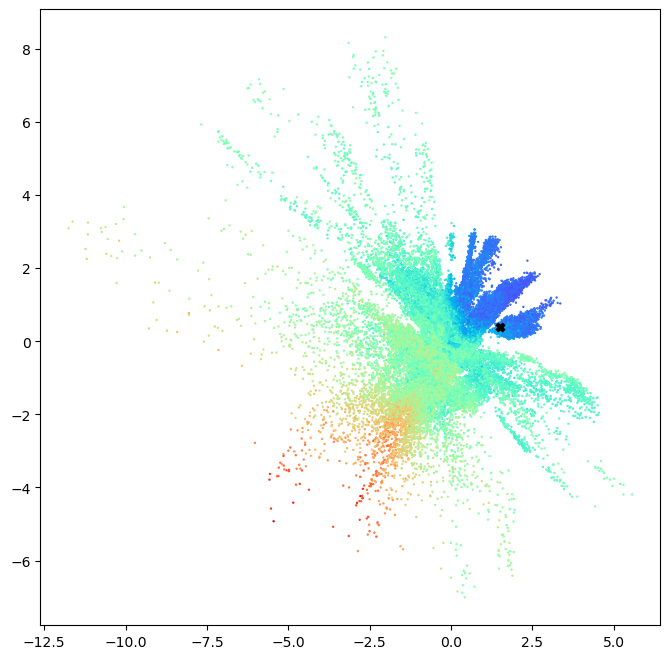

In [12]:
target = np.array([0,-2]).reshape(1, latent_dim)
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, tr, test, bb_indices, model=nn_model, exact=False)

In [13]:
rms_ref = md.load_pdb(conf)
rms_ref_bb  = rms_ref.atom_slice(bb_indices)
rms_ref_ca  = rms_ref.atom_slice(ca_indices)
rms_tr = md.load_xtc(tr, top=rms_ref)
rmsd = md.rmsd(rms_tr, rms_ref)

In [14]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

In [15]:
s = decoder.predict(sample)

coords_size = coords.shape[1]  # dimensione delle coordinate
angles_size = s.shape[1] - coords_size  # dimensione degli angoli

# Separa coordinate e angoli
s_coords = s[:, :coords_size]
s_angles = s[:, coords_size:]

# Inverti le trasformazioni separatamente
coords_orig = scaler_coords.inverse_transform(s_coords)
angles_orig = scaler_angles.inverse_transform(s_angles)

# Prendi solo le coordinate per la ricostruzione
coords_flat = coords_orig[0, :]                    
coords_p = coords_flat.reshape((n_p, 3))
mask_bb = np.isin(p_indices, bb_indices)
coords_bb = coords_p[mask_bb] 
coords_ca = coords_bb[1::4] 

new_traj = md.Trajectory(
    xyz=np.array([coords_bb]),     
    topology=rms_ref_bb.topology     
)

new_traj.save_pdb("./models/vae_reconstructed.pdb")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


In [16]:
view = nv.show_file('./models/vae_reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

NGLWidget()

In [17]:
mse = np.mean((s[0] - sample_x.numpy())**2)
print("MSE ricostruzione:", mse)

MSE ricostruzione: 0.031913716


/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/prj/ASMSA/mydev/src/asmsanalysis.py:117: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tedeschg/miniforge3/envs/asmsa/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: User

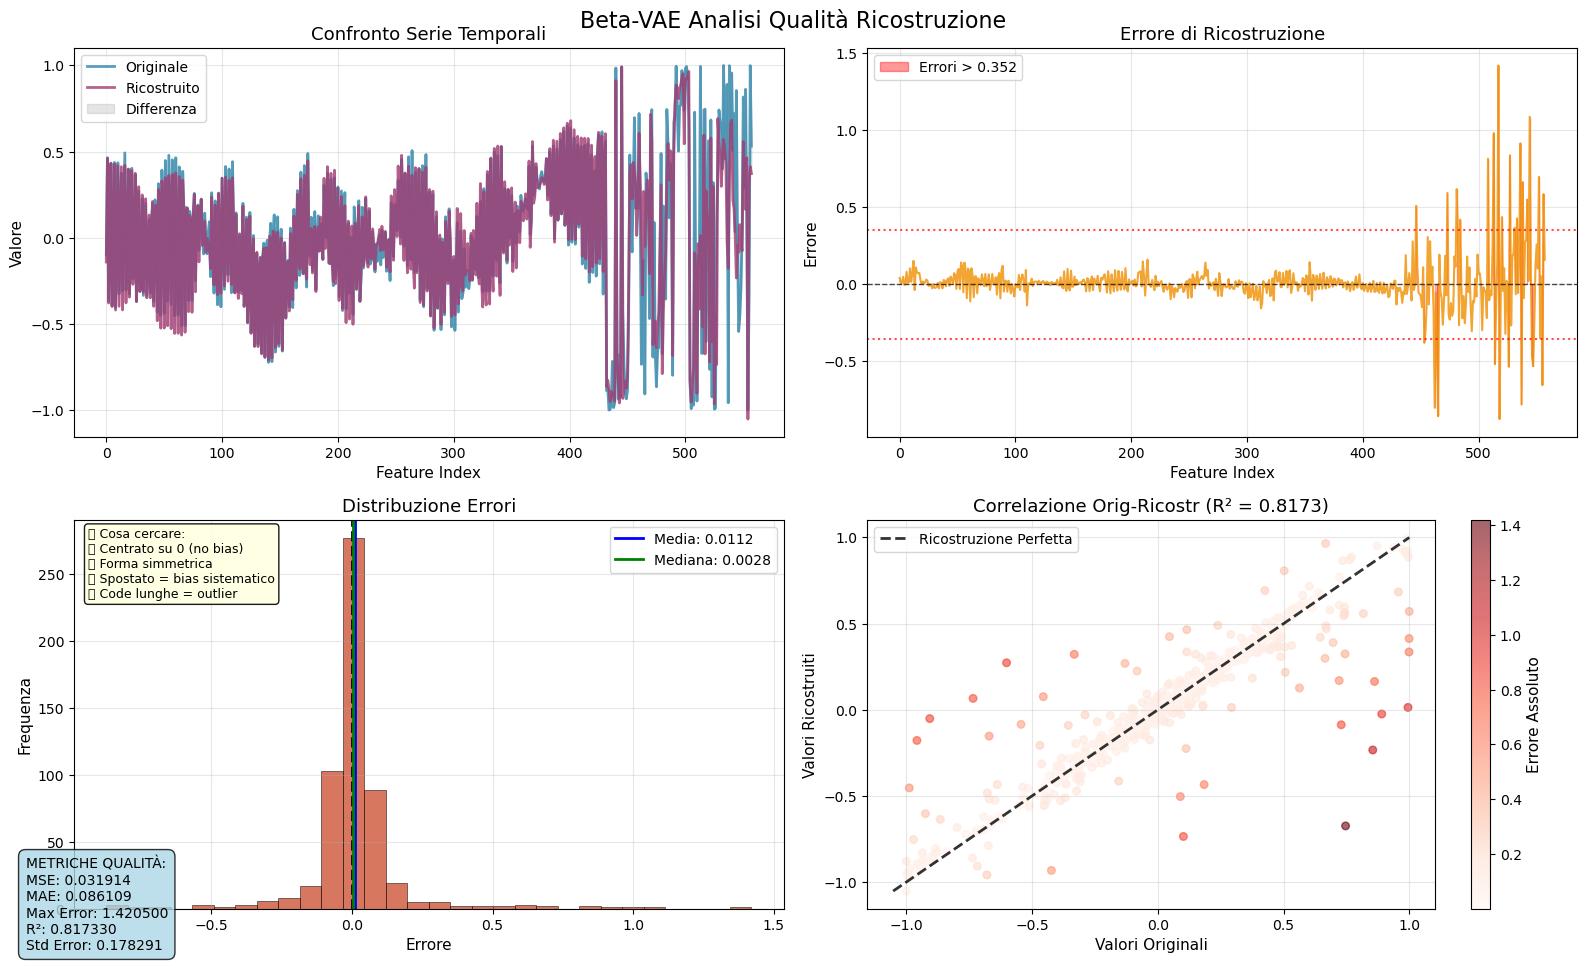

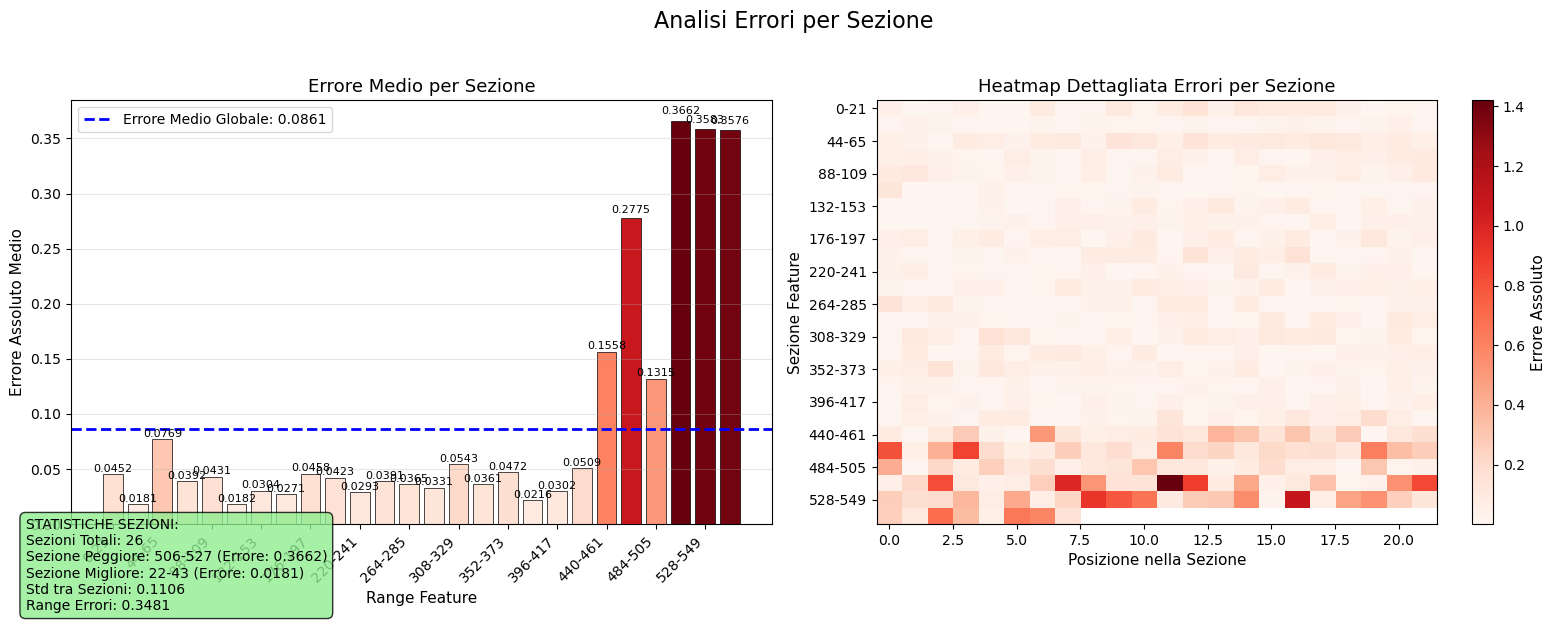


=== METRICHE RICOSTRUZIONE ===


In [18]:
from src.asmsanalysis import analyze_reconstruction, plot_section_errors
import matplotlib.pyplot as plt
# Utilizzo con i tuoi dati
# Assumendo che sample_x e s[0] siano definiti
orig = sample_x.numpy() 
recon = s[0]

# Analisi completa
fig, metrics = analyze_reconstruction(orig, recon, title_prefix="Beta-VAE ")

# Solo errori per sezione
fig_sections, section_stats = plot_section_errors(orig, recon, n_sections=25, 
                                                   title="Analisi Errori per Sezione")

plt.show()

# Stampa metriche
print("\n=== METRICHE RICOSTRUZIONE ===")
for metric, value in metrics.items():
    (f"{metric.upper()}: {value:.6f}")

In [19]:
import nglview as nv

# Crea un widget vuoto
view = nv.NGLWidget()

# --- primo modello -------------------------------------------------
comp1 = view.add_component("./models/vae_reconstructed.pdb")   # oppure percorso al tuo 1° PDB
comp1.clear_representations()                         # opzionale
comp1.add_representation("line", color="skyblue")  # o 'line', 'surface', ecc.

# --- secondo modello ----------------------------------------------
comp2 = view.add_component("./models/ae_reconstructed.pdb")       # secondo PDB da sovrapporre
comp2.clear_representations()
comp2.add_representation("line", color="orange")   # scegli un colore diverso

# Centra e mostra
view.center()
view


NGLWidget()